In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
from scipy import interpolate

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # changes per computer
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 19/05/2020 11:09:34


In [9]:
opt_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 75,
             'ring_width': 5}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
test_oap =  'A'

# open the file mask to get header content
mask_hdr = fits.open(data_folder+'oap{0}_{1}CA_mask.fits'.format(test_oap, opt_parms['ca']))[0].header

# calculate the difference for reducing the clear aperture
d_new = (7.6*u.mm).to(u.m)
npix_diam_new = int(d_new/(mask_hdr['latres']*u.m))
if (npix_diam_new % 2) != 0:
    resize_diff = mask_hdr['naxis1'] - npix_diam_new - 1
else:
    resize_diff = mask_hdr['naxis1'] - npix_diam_new
    
# open each optic, but resize it down and save it
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')

for surface_name in oap_labels:
    # call in the file
    fileloc=data_folder+'oap{0}_{1}CA'.format(surface_name, opt_parms['ca'])
    surf, mask, sp = dfx.open_fits(filename=fileloc, diam_ca100=50*u.mm)
    
    # undersize the matrix equally
    surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=resize_diff)
    if mask.shape[0] % 2 != 0: # this is a bug in my code that I can't figure out how to fix
        surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=1)
    
    latres = sp['value'][sp['label'].index('latres')]
    diam = (latres * mask.shape[0]*u.pix).to(u.mm)
    clear_ap = diam / sp['value'][sp['label'].index('diam_100')] * 100
        
    # write to file
    new_filename = 'oap{0}_{1}CA'.format(surface_name, int(clear_ap))
    #dfx.write_fits(surface=surf, mask=mask, surf_parms=sp, filename=data_folder+new_filename)
    print('n{0:5} | diameter: {1:.3f} | clear ap: {2:.2f}% | shape: {3} | name: {4}'.format(surface_name, diam, clear_ap, mask.shape, new_filename))

nA     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapA_15CA
nB     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapB_15CA
nC     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapC_15CA
nD     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapD_15CA
nE     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapE_15CA
nF     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapF_15CA
nG     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapG_15CA
nH     | diameter: 7.712 mm | clear ap: 15.42% | shape: (46, 46) | name: oapH_15CA


In [3]:
%%time
new_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 15,
             'ring_width': 5}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')
oap=[]

for surface_name in oap_labels:
    n_step = 'OAP {0}'.format(surface_name)
    file_loc=data_folder+'oap{0}_{1}CA'.format(surface_name, new_parms['ca'])
    # create the object
    opt = psd.surfPSD(surf_name = n_step)
    opt.open_surf(fileloc=file_loc+'_surf.fits', surf_units = new_parms['surf_units'])
    opt.open_mask(fileloc=file_loc+'_mask.fits')
    opt.calc_psd(oversamp = new_parms['ovs'], kmid_ll=1/u.mm, khigh_ll=1/u.mm)
    print('PSD for {0} complete'.format(n_step))
    opt.calc_psd_radial(ring_width=new_parms['ring_width'])
    print('Radial profile for {0} complete\n'.format(n_step))
    oap.append(opt)

PSD for OAP A complete
Radial profile for OAP A complete

PSD for OAP B complete
Radial profile for OAP B complete

PSD for OAP C complete
Radial profile for OAP C complete

PSD for OAP D complete
Radial profile for OAP D complete

PSD for OAP E complete
Radial profile for OAP E complete

PSD for OAP F complete
Radial profile for OAP F complete

PSD for OAP G complete
Radial profile for OAP G complete

PSD for OAP H complete
Radial profile for OAP H complete

CPU times: user 4min 44s, sys: 1min 42s, total: 6min 27s
Wall time: 6min 15s


In [4]:
oap[0].rms_l, oap[0].rms_m, oap[0].rms_h

(<Quantity 13.00051252 nm>, <Quantity 0. nm>, <Quantity 1.69825996 nm>)

In [6]:
# calculate the average PSD from the normalized set from all optics
# flatten the data from the normalized set
flat_norm = np.zeros((len(oap), new_parms['ovs']*new_parms['ovs']))
flat_var = np.zeros((len(oap)))
for n in range(0, len(oap)):
    flat_norm[n] = oap[n].psd_norm.reshape(new_parms['ovs']*new_parms['ovs'])
    flat_var[n] = oap[n].var.value
# calculate the average flat
norm_psd_avg = np.mean(flat_norm, axis=0).reshape(new_parms['ovs'], new_parms['ovs'])*oap[0].psd_norm.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*oap[0].var.unit
cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by making its own object
avg_psd = psd.surfPSD(surf_name='oap_avg')
avg_psd.load_psd(psd_data=cal_psd_avg, psd_type='cal', var=var_avg)
avg_psd.load_psd_parameters(oversamp=oap[0].oversamp,
                            diam_ca=oap[0].diam_ca,
                            npix_diam=oap[0].npix_diam,
                            wavelen=oap[0].wavelen)
avg_psd.calc_rms_set(kmid_ll=1/u.mm, khigh_ll=1/u.mm, pwr_opt=avg_psd.psd_cal)
#avg_psd.write_psd_file(filename=ddata_folder+'oap_avg_{0}CA'.format(new_parms['ca']),
#                       psd_data = avg_psd.psd_cal,
#                      single_precision=False)
avg_psd.calc_psd_radial(ring_width=new_parms['ring_width'])
print('PSD and radial profile for all dust masked in averaged surface complete.')

PSD and radial profile for all dust masked in averaged surface complete.


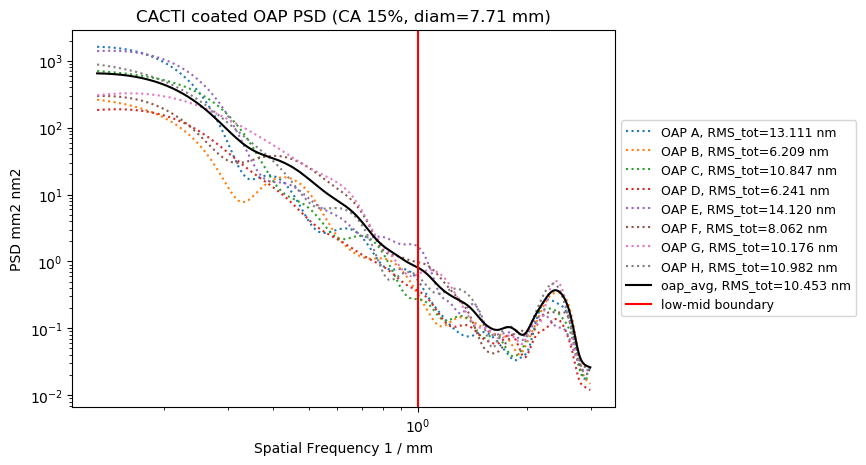

In [28]:
plt.figure(figsize=[7,5], dpi=100)
for obj in oap:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS_tot={1:.3f}'.format(obj.surf_name, obj.rms_tot))
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_tot={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_tot))
plt.axvline(x=1.0, color='r', label='low-mid boundary')
plt.xlabel('Spatial Frequency {0}'.format(oap[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(oap[0].psd_radial_cal.unit))
plt.title('CACTI coated OAP PSD (CA {0}%, diam={1:.2f})'.format(new_parms['ca'], diam))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

Something weird happened for the higher spatial frequency content to show a very large bump. Maybe investigate later.

### Calculate the RMS at low, mid, high spatial frequency bands.
Note that the low-mid spatial frequency range has been adjusted compared to other notebooks.

In [29]:
# Evaluate the rms at low, mid, high spatial frequency 
print('RMS calculations')
print('k_min: {0:.4f}'.format(oap[0].k_min))
print('k_max: {0:.4f}'.format(oap[0].k_max))
print('k_low-mid_boundary: {0:.4f}'.format(oap[0].khigh_ll))
print('{0:>7} | {1:^9} | {2:^10} | {3:^10}'.format('optic', 'low-mid', 'high', 'total'))
for obj in oap:
    print('{0:>7} | {1:6.3f} | {2:7.3f} | {3:>7.3f} '.format(obj.surf_name, obj.rms_l, obj.rms_h, obj.rms_tot))
# print average PSD
print('{0:>7} | {1:6.3f} | {2:7.3f} | {3:>7.3f} '.format(avg_psd.surf_name, avg_psd.rms_l, avg_psd.rms_h, avg_psd.rms_tot))

RMS calculations
k_min: 0.1297 1 / mm
k_max: 2.9825 1 / mm
k_low-mid_boundary: 1.0000 1 / mm
  optic |  low-mid  |    high    |   total   
  OAP A | 13.001 nm |   1.698 nm |  13.111 nm 
  OAP B |  5.926 nm |   1.855 nm |   6.209 nm 
  OAP C | 10.730 nm |   1.591 nm |  10.847 nm 
  OAP D |  6.084 nm |   1.390 nm |   6.241 nm 
  OAP E | 14.005 nm |   1.797 nm |  14.120 nm 
  OAP F |  7.842 nm |   1.872 nm |   8.062 nm 
  OAP G |  9.945 nm |   2.155 nm |  10.176 nm 
  OAP H | 10.767 nm |   2.162 nm |  10.982 nm 
oap_avg | 10.234 nm |   2.131 nm |  10.453 nm 
